In [22]:
import pymc3 as pm
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import numpy.random as npr

from model import make_model, sample_model, plot_forestplots

sns.set_context('poster')
sns.set_style('white')
%matplotlib inline

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Simulation Data

In systematically measuring genotype-phenotype data, how will the data be collected, stored and analyzed? Is a small laptop enough to model the fold change calculations locally? I explore this in the following notebook.

In [23]:
def make_simulated_data(n_reps_low, n_reps_high, n_genotypes):
    means = npr.randint(low=10, high=100, size=n_genotypes)
    means = means * (means > 0)  # negative activities are not captured
    sds = npr.random(size=n_genotypes) * 10
    num_measurements = npr.randint(low=n_reps_low, high=n_reps_high, size=n_genotypes)

    # Create simulated data.
    data = []
    indices = []

    for i in range(n_genotypes):
        n = num_measurements[i]
        mean = means[i]
        sd = sds[i]

        measurements = npr.normal(loc=mean, scale=sd, size=n)
        # print(measurements)
        measurements = measurements * (measurements > 0)
        # print(measurements)

        data.extend(measurements.tolist())
        indices.extend([i] * n)

    # Add baseline measurements (bl_measures)
    n_bl_measures = n_reps_high - 1
    bl_measures = npr.normal(loc=1.0, scale=0.1, size=n_bl_measures)
    bl_measures = bl_measures * (bl_measures > 0)
    data.extend(bl_measures)
    indices.extend([n_genotypes] * n_bl_measures)
    num_measurements = np.append(num_measurements, n_bl_measures)
    means = np.append(means, bl_measures.mean())
    sds = np.append(sds, bl_measures.std())

    # Add pos_ctrl measurements (pc_measures)
    n_pc_measures = n_reps_high - 1
    pc_measures = npr.normal(loc=20.0, scale=1, size=n_pc_measures)
    pc_measures = pc_measures * (pc_measures > 0)
    data.extend(pc_measures)
    indices.extend([n_genotypes + 1] * n_pc_measures)
    num_measurements = np.append(num_measurements, n_pc_measures)
    means = np.append(means, pc_measures.mean())
    sds = np.append(sds, pc_measures.std())

    # convert indices to a numpy array
    indices = np.array(indices)

    return data, indices, num_measurements, means, sds,

In [24]:
# Set n_genotypes > 1000 to obtain estimates of variance in error as a function of num_measurements
# Set n_genotypes < 15 to obtain diagnostic plots (traceplot) and comparison of modelled to actual.
# You've been forewarned - for the diagnostics and modelled, plotting with > 100 takes a while...
n_genotypes = 500
n_reps_low = 5
n_reps_high = 6

sim_data = make_simulated_data(n_genotypes=n_genotypes, n_reps_low=n_reps_low, n_reps_high=n_reps_high)
data, indices, num_measurements, means, sds = sim_data

In [25]:
# Compute the "actual" Z'-factor for the assay.
zp_det = 1 - (3 * sds[-2] + 3 * sds[-1]) / np.abs(means[-2] - means[-1])
zp_det

0.7378967470865283

In [26]:
model = make_model(n_genotypes, data, indices)

Applied log-transform to upper and added transformed upper_log_ to model.
Applied interval-transform to fold and added transformed fold_interval_ to model.
Applied log-transform to sigma and added transformed sigma_log_ to model.


In [27]:
%%time
trace = sample_model(model, n_genotypes)

Iteration 0 [0%]: ELBO = -20183428.15
Iteration 30000 [10%]: Average ELBO = -1124112.37
Iteration 60000 [20%]: Average ELBO = -9482.67
Iteration 90000 [30%]: Average ELBO = -9206.02
Iteration 120000 [40%]: Average ELBO = -9105.16
Iteration 150000 [50%]: Average ELBO = -9073.35
Iteration 180000 [60%]: Average ELBO = -9062.27
Iteration 210000 [70%]: Average ELBO = -9059.3
Iteration 240000 [80%]: Average ELBO = -9058.87
Iteration 270000 [90%]: Average ELBO = -9058.79
Finished [100%]: Average ELBO = -9058.75
CPU times: user 2min 30s, sys: 1.66 s, total: 2min 32s
Wall time: 2min 40s


In [28]:
if n_genotypes <= 15:
    plot_forestplots(trace)

In [29]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['z_factor', 'zp_factor'], vline=0.5)
    plt.xlim(-1, 1)
    plt.savefig('../figures/z-factor_sim.pdf', bbox_inches='tight')

In [30]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['fold'])
    plt.savefig('../figures/foldchange.pdf', bbox_inches='tight')

In [31]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['sigma'])
    plt.savefig('../figures/sigma.pdf', bbox_inches='tight')

In [32]:
if n_genotypes <= 15:
    pm.forestplot(trace, varnames=['fold_changes'])
    plt.savefig('../figures/fold_changes.pdf', bbox_inches='tight')

In [33]:
if n_genotypes <= 15:
    pm.summary(trace)

In [34]:
if n_genotypes <= 15:
    pm.traceplot(trace)

# Error in Estimated Mean

What is the error in estimated mean as a function of the number of measurements?

In [35]:
num_measurements

array([5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5,
       5, 5,

In [36]:
trace['fold'].mean(axis=0) - means

array([ -9.83991525e-01,  -2.26415044e+00,  -3.47569545e-01,
        -1.93065176e+00,  -1.83202672e-01,  -9.10121985e-01,
        -1.89491958e+00,   1.03229431e+00,  -2.89094543e-01,
        -9.55053248e-01,   5.69276961e-01,  -4.65607293e-01,
         6.41654760e-01,  -4.74736230e+00,  -2.63661532e+00,
        -3.01513969e-01,   3.94814484e+00,   2.57146308e-01,
        -1.12956536e+00,  -2.56894240e+00,  -2.13821727e-01,
        -5.16257318e-01,  -2.21101810e+00,  -5.14328099e+00,
         1.83679859e+00,  -2.40441998e-01,  -4.24085234e+00,
        -1.96431786e-01,  -2.09633415e-02,   1.31152219e+00,
         2.68595422e-01,   1.63239717e+00,  -1.14337911e+00,
         9.60332298e-01,  -4.92211145e-01,   6.16662526e+00,
         1.19924472e+00,   9.59000597e-01,   8.80708112e-01,
         1.58972606e+00,  -2.46382202e+00,   1.96321909e+00,
        -3.18910879e+00,  -9.46810710e-02,  -3.00913391e+00,
        -4.31181930e+00,  -2.51669905e+00,  -5.30189965e-01,
        -1.71194944e+00,

In [37]:
import pandas as pd
errors_df = pd.DataFrame([num_measurements, (trace['fold'].mean(axis=0) - means)]).T
errors_df.columns = ['num_measurements', 'error_means']
errors_df.head()

,num_measurements,error_means
0,5.0,-0.983992
1,5.0,-2.264150
2,5.0,-0.347570
3,5.0,-1.930652
4,5.0,-0.183203


In [39]:
if n_genotypes >= 500 and n_reps_high - n_reps_low > 1:
    sns.boxplot(data=errors_df, x='num_measurements', y='error_means')
    ax = plt.gca()
    labels = ax.get_xticklabels()
    # plt.xticks(x=sorted(list(set(errors_df['num_measurements']))), )
    plt.xticks(rotation=90)
    plt.ylabel('Error in Fold Change')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/error-means.pdf', bbox_inches='tight')
    
    errors_df.groupby('num_measurements').var().plot(legend=False)
    plt.ylabel('Variance in Error')
    plt.xlabel('Num. Measurements')
    plt.savefig('../figures/var-error-means.pdf', bbox_inches='tight')

In [40]:
(trace['fold'].mean(axis=0) - means).mean()

-0.18564916237512394

In [41]:
if n_genotypes <= 15:
    plt.figure()
    pm.traceplot(trace, varnames=['fold'])
    plt.figure()

# Compare modelled to actual

In [42]:
trace['fold'].mean(axis=0)

array([ 19.01600847,  79.73584956,  93.65243045,  38.06934824,
        55.81679733,  17.08987802,  68.10508042,  76.03229431,
        31.71090546,  28.04494675,  96.56927696,  47.53439271,
        37.64165476,  15.2526377 ,  31.36338468,  33.69848603,
        30.94814484,  62.25714631,  15.87043464,  90.4310576 ,
        69.78617827,  64.48374268,  44.7889819 ,  49.85671901,
        53.83679859,  17.759558  ,  74.75914766,  69.80356821,
        77.97903666,  77.31152219,  50.26859542,  23.63239717,
        74.85662089,  47.9603323 ,  65.50778886,  92.16662526,
        23.19924472,  89.9590006 ,  54.88070811,  41.58972606,
        26.53617798,  61.96321909,  92.81089121,  43.90531893,
        28.99086609,  61.6881807 ,  71.48330095,  54.46981004,
        58.28805056,  93.29880213,  51.79873639,  20.06459397,
        29.83240215,  60.54198096,  22.74858472,  55.11913111,
        54.21739417,  86.61279466,  57.62199629,  53.53595296,
        74.82927641,  95.46449943,  73.58846762,  65.18

In [43]:
trace['fold'].mean(axis=0).shape

(502,)

In [44]:
np.arange(1, n_genotypes+3).shape

(502,)

In [45]:
if n_genotypes <= 15:
    fig = plt.figure()
    ax = fig.add_subplot(111)
    lower = trace['fold'].mean(axis=0) - np.percentile(trace['fold'], 2.5, axis=0)
    upper = np.percentile(trace['fold'], 97.5, axis=0) - trace['fold'].mean(axis=0)
    yerr_pos = [lower, upper]
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=trace['fold'].mean(axis=0), 
                # y-error bars
                yerr=yerr_pos,
                # styling
                color='blue', ls='none', alpha=0.5, label='modeled',)
    ax.scatter(x=np.arange(1, n_genotypes+3), y=means, 
               # styling
               color=['red'] * (n_genotypes) + ['green'] + ['blue'], marker='o', s=100, label='true mean',)
    ax.errorbar(x=np.arange(1, n_genotypes+3), y=means,
               yerr=sds,
               color='red', ls='none', alpha=0.5, label='true var')
    ax.legend(loc='upper left', frameon=False)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-2], linestyles='--', alpha=0.2)
    ax.hlines(xmin=0, xmax=n_genotypes+3, y=trace['fold'].mean(axis=0)[-1], alpha=0.2)
    ax.set_xlabel('genotype ID')
    ax.set_ylabel('fold change')
    # ax.set_xlim(, n_genotypes+2)

In [46]:
if n_genotypes <= 15:
    fig = plt.figure()
    pm.forestplot(trace, vline=1, varnames=['fold'])
print('just for checking the above plot...')

just for checking the above plot...


## How often is the true mean inside the 95% HPD?

In [53]:
lower, upper = np.percentile(trace['fold'], [2.5, 97.5], axis=0)
lower, upper

(array([ 15.63308804,  75.65250665,  92.35259734,  35.37227628,
         46.86907809,  11.65122809,  62.49992335,  71.24902629,
         26.44246194,  19.37127173,  84.91297867,  47.10599781,
         34.63688183,   8.09156752,  26.26570113,  32.52367808,
         26.07629278,  52.39513949,  13.96103347,  86.4606837 ,
         67.07300373,  59.72243381,  35.58706751,  47.52014389,
         44.9635819 ,  17.12872136,  70.72669838,  66.44109291,
         77.93071746,  75.84190867,  48.96289088,  18.56158746,
         73.50968874,  44.2132445 ,  61.08951082,  87.13922412,
         17.04140641,  87.17125144,  50.60680068,  39.36541765,
         22.61632963,  59.21019526,  81.62127292,  42.94263064,
         22.22122766,  54.07884165,  67.8748559 ,  53.15553592,
         54.18508833,  86.46650373,  49.55298272,  18.34534175,
         27.17039645,  50.57163733,  22.41994781,  51.80601458,
         51.27592076,  84.5797613 ,  55.10972893,  49.12163133,
         73.67718414,  94.63626019,  66.

In [54]:
means

array([ 20.        ,  82.        ,  94.        ,  40.        ,
        56.        ,  18.        ,  70.        ,  75.        ,
        32.        ,  29.        ,  96.        ,  48.        ,
        37.        ,  20.        ,  34.        ,  34.        ,
        27.        ,  62.        ,  17.        ,  93.        ,
        70.        ,  65.        ,  47.        ,  55.        ,
        52.        ,  18.        ,  79.        ,  70.        ,
        78.        ,  76.        ,  50.        ,  22.        ,
        76.        ,  47.        ,  66.        ,  86.        ,
        22.        ,  89.        ,  54.        ,  40.        ,
        29.        ,  60.        ,  96.        ,  44.        ,
        32.        ,  66.        ,  74.        ,  55.        ,
        60.        ,  96.        ,  49.        ,  23.        ,
        29.        ,  62.        ,  23.        ,  53.        ,
        54.        ,  86.        ,  57.        ,  54.        ,
        75.        ,  95.        ,  77.        ,  66.  

In [55]:
# Here is the fraction of means that have been correctly included within the 95% HPD.
sum((means > lower) *  (means < upper)) / len(means)

0.90438247011952189

## What is the distribution of SEM vs. 95% CI vs. Bayesian 95% HPD?

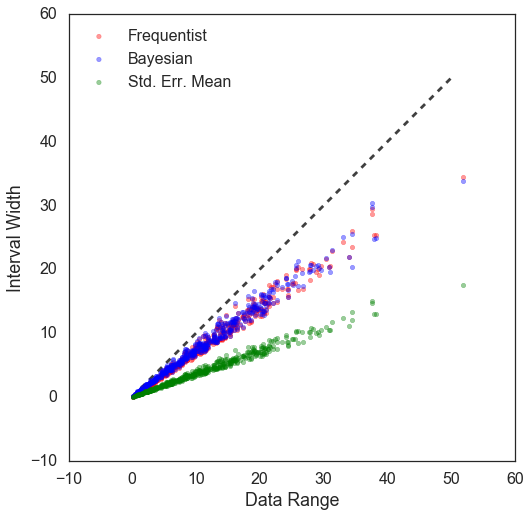

In [107]:
df = pd.DataFrame()
df['measurements'] = data
df['indices'] = indices
df.groupby('indices').std()

errorbars = pd.DataFrame()
errorbars['SEM'] = 2 * df.groupby('indices').std()['measurements'] / np.sqrt(num_measurements)
errorbars['Frequentist'] = 1.96 * errorbars['SEM']
errorbars['Bayesian'] = upper - lower
errorbars['Data'] = df.groupby('indices')['measurements'].max() - df.groupby('indices')['measurements'].min()
# errorbars['Data'] = df.groupby('indices')['measurements'].var

alpha = 0.4
fig = plt.figure(figsize=(8,8))
ax = fig.add_subplot(111)
# ax.set_aspect('equal')
ax.scatter(x=errorbars['Data'], y=errorbars['Frequentist'], color='red', label='Frequentist', alpha=alpha)
ax.scatter(x=errorbars['Data'], y=errorbars['Bayesian'], color='blue', label='Bayesian', alpha=alpha)
ax.scatter(x=errorbars['Data'], y=errorbars['SEM'], color='green', label='Std. Err. Mean', alpha=alpha)

lims = [
    0,  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]) - 10,  # max of both axes
]

# now plot both limits against eachother
ax.plot(lims, lims, 'k--', alpha=0.75, zorder=0)
ax.legend(loc='upper left')
ax.set_ylabel('Interval Width')
ax.set_xlabel('Data Range')
plt.savefig('../figures/simulation-range-estimates.pdf', bbox_inches='tight')